In [1]:
from collections import Counter
from sklearn.cluster import KMeans
import numpy as np
import cv2

'''
To. 진형님
각함수에 주석은 달아 놓았지만

직접 사용하셔야 할 함수는 
'color_list' 함수입니다.
기능은 이미지랑 박스들 리스트를 받으면 index순서에 맞추어서
[[배경색, 글자색],
[배경색, 글자색],
...
[배경색, 글자색]]

인 list를 뱉어주게 만들었습니다.

파일 위치는 server/modules에 있습니다.
'''

# 이미지를 필요한 부분만 cutting 해줌
def cutting_img(img, box):

    # 변환 전 4개 좌표 
    pts1 = np.float32(box)

    width = 180 # 두 좌우 거리간의 최대값이 서류의 폭
    height = 32 # 나오는 글씨의 높이
    
    # 변환 후 4개 좌표
    pts2 = np.float32([[0,0], [width-1,0], 
                        [width-1,height-1], [0,height-1]])

    # 변환 행렬 계산 
    mtrx = cv2.getPerspectiveTransform(pts1, pts2)
    # 원근 변환 적용
    result = cv2.warpPerspective(img, mtrx, (width, height))
    return result

# 이미지상 색이 많은 것부터 순서대로 팔레트를 뱉어줌
# 이건 시각화를 위해서 만듬
def palette_perc(img):
    clt = KMeans(n_clusters=3)
    k_cluster = clt.fit(img.reshape(-1, 3))
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items(), key = lambda item: item[1], reverse = True))
    
    #for logging purposes
    print(perc)
    print(k_cluster.cluster_centers_)
    
    step = 0
    
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
        
    return palette

# 이미지를 받으면 색이 많은것, 2번째로 많은 것을 return
def Find_MuchColor(img):
    clt = KMeans(n_clusters=3)
    k_cluster = clt.fit(img.reshape(-1, 3))
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = sorted(perc.items(), key = lambda item: item[1], reverse = True)
    
    return [k_cluster.cluster_centers_[perc[0][0]], k_cluster.cluster_centers_[perc[1][0]]]

# 이미지와 박스 리스트를 받으면 index 순서에 맞추어 배경, 글자색순으로 return
def color_list(img, box_list):
    colors_in_img = []
    for box in box_list:
        cutted_img = cutting_img(img,box)
        colors = Find_MuchColor(cutted_img)
        colors_in_img.append(colors)
        
    return colors_in_img

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

In [4]:
img = cv2.imread("/opt/ml/final_project/final-project-level3-cv-07/models/datasets/tested_images/가보.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

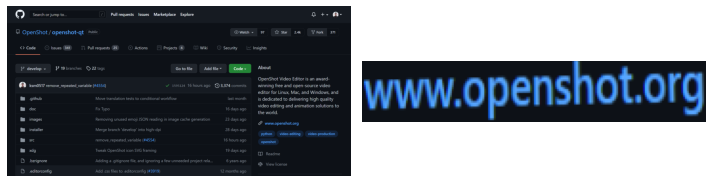

In [5]:
box = [[1420,633],[1608,636],[1607,659],[1420,656]]
       
cutted_box = cutting_img(img,box)

show_img_compar(img, cutted_box)

{2: 0.68, 1: 0.21, 0: 0.12}
[[ 38.73412112  75.85081241 129.71639586]
 [ 70.60185968 146.68131868 233.3465765 ]
 [ 14.28923077  19.01487179  26.23538462]]


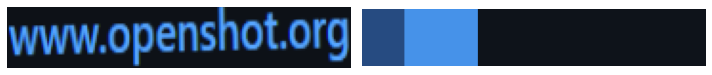

In [6]:
show_img_compar(cutted_box, palette_perc(cutted_box))

In [7]:
box_list = [[[1420,633],[1608,636],[1607,659],[1420,656]],
[[1400,739],[1481,737],[1482,756],[1400,758]],
[[81,128],[224,131],[224,165],[81,163]]]

for i in color_list(img, box_list) :
    print(i)

[array([14.32838875, 19.0859335 , 26.36777494]), array([ 70.86604096, 147.06911263, 233.75085324])]
[array([20.83347234, 37.71809842, 62.06588824]), array([ 71.52717391, 149.33385093, 235.55124224])]
[array([13.85578704, 18.26111111, 24.81805556]), array([ 72.48156182, 149.01843818, 234.90347072])]
